In [1]:
import os, sys
import joblib
import importlib

import pandas as pd
import polars as pl
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dproc, sgml, sgutil, sgpp, custpp

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

print(sys.version)
for i in [pd, pl, mpl, sns, np, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
lightgbm 4.3.0
catboost 1.2.5
xgboost 2.1.2


In [2]:
df_train = pd.read_parquet(os.path.join('data', 'train.parquet'))
df_test = pd.read_parquet(os.path.join('data', 'test.parquet'))
target = 'num_sold'

In [3]:
df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target] = df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target].fillna(5)
df_train.loc[(df_train['product'] == 'Kerneler'), target] = \
    df_train.loc[(df_train['product'] == 'Kerneler')].groupby(['country', 'store'], observed = False)[target].transform(
        lambda x: x.interpolate()
    )
df_ratio_product = df_train.loc[~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['product'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_country = df_train.loc[df_train['product'] != 'Holographic Goose'].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['country'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_store = df_train.loc[(df_train['product'] != 'Holographic Goose') & ~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['store'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
X_key = ['country', 'store', 'product']
df_ratio = pd.DataFrame(
    0,
    columns = pd.MultiIndex.from_product(df_train[X_key].apply(lambda x: x.unique().tolist())),
    index = df_train['days'].unique()
).apply(
    lambda x: df_ratio_country.loc[:, x.name[0]] * df_ratio_store.loc[:, x.name[1]] * df_ratio_product.loc[:, x.name[2]]
)
df_ratio_notna = pd.DataFrame(
    df_ratio.values * df_train.assign(target_notna = lambda x: x[target].notna()).pivot(
        index = 'days', columns = X_key, values = 'target_notna'
    ).values, index = df_ratio.index, columns = df_ratio.columns
)
s_est_daily_sum = df_train.groupby('days')[target].sum() * 1 / df_ratio_notna.sum(axis = 1)

df_train.loc[df_train[target].isna(), target] = df_train.loc[df_train[target].isna()].apply(
    lambda x: df_ratio.loc[x['days'], tuple(x[X_key])] * s_est_daily_sum.loc[x['days']], axis = 1
)

In [4]:
df_m = df_train.groupby(['country', 'store', 'product'], observed = True)['num_sold'].mean()
df_train['m'] = df_train[['country', 'store', 'product']].apply(tuple, result_type='reduce', axis=1).map(df_m)
df_test['m'] = df_test[['country', 'store', 'product']].apply(tuple, result_type='reduce', axis=1).map(df_m)
df_train['ns_std'] = df_train['num_sold'] / df_train['m']

<Axes: xlabel='days', ylabel='ns_std'>

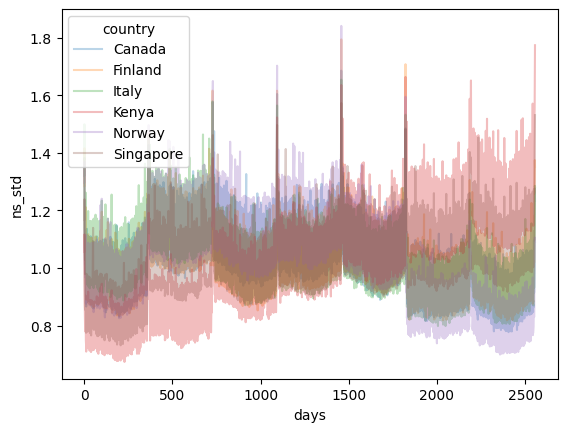

In [5]:
sns.lineplot(
    df_train.groupby(['days', 'country'], as_index = False)['ns_std'].mean(), x = 'days', y = 'ns_std', hue = 'country',
    alpha = 0.3
)

<Axes: xlabel='days', ylabel='ns_std'>

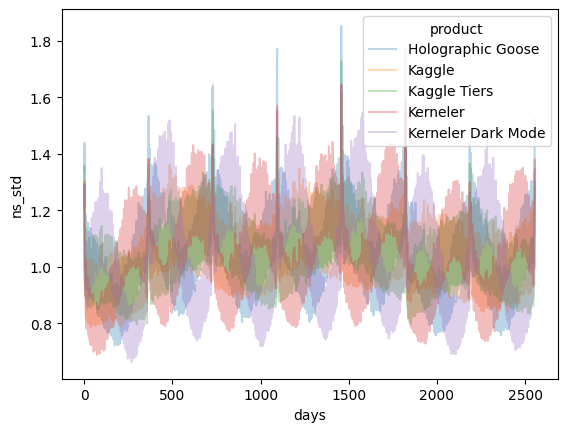

In [6]:
sns.lineplot(
    df_train.groupby(['days', 'product'], as_index = False, observed = True)['ns_std'].mean(), x = 'days', y = 'ns_std', hue = 'product',
    alpha = 0.3
)

<Axes: xlabel='days', ylabel='ns_std'>

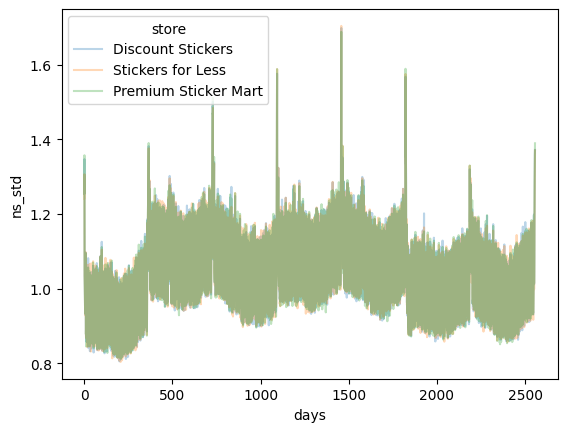

In [7]:
sns.lineplot(
    df_train.groupby(['days', 'store'], as_index = False, observed = True)['ns_std'].mean(), x = 'days', y = 'ns_std', hue = 'store',
    alpha = 0.3
)

In [8]:
df_train.groupby('holiday', observed = True)['ns_std'].mean()

holiday
etc                 1.042193
None                0.998511
New Year's Day      1.229559
Labour Day          0.986995
Christmas Day       1.074341
Good Friday         0.999288
Chinese New Year    1.009668
Name: ns_std, dtype: float32

In [9]:
df_train.groupby('year', observed = True)['ns_std'].mean()

year
2010    0.914581
2011    1.049625
2012    1.013222
2013    1.046465
2014    1.042410
2015    0.961820
2016    0.971918
Name: ns_std, dtype: float32

In [11]:
s_gdp_mean = df_train.groupby('country')['gdp'].mean()
df_train['gdp_std'] = df_train['gdp'] / df_train['country'].map(s_gdp_mean)
df_test['gdp_std'] = df_test['gdp'] / df_test['country'].map(s_gdp_mean)

In [12]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

def split(x, splitter, groups):
    for train_idx, valid_idx in splitter.split(x, x[target], groups = groups):
        return x.iloc[train_idx], x.iloc[valid_idx]

def get_validation_splitter(validation_fraction):
    gss = GroupShuffleSplit(n_splits = 1, train_size = 0.7, random_state = 123)
    return lambda x: split(x, gss, x['md'])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: -mean_absolute_percentage_error(df[target].sort_index(), (prds * df['m'] ).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'groups': 'year',
    'y': 'num_sold',
    'target_func': lambda a, b: b / a['m'],
}

gss = GroupShuffleSplit(n_splits = 1, random_state = 123)
gkf = GroupKFold(n_splits = 4)

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)

In [19]:
lgb1 = sgml.CVModel('model', 'lgb2_1', gkf, config, lgb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 2000, 'num_leaves': 31, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_cat': ['weekday', 'country', 'store', 'product', 'holiday', 'month'],
    #'validation_fraction': 0.2
}
#result = lgb1.adhoc(df_train, gss, hparams)
result = lgb1.cv(df_train, hparams)
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([-0.06239310046968709,
  -0.04975821663151798,
  -0.05899762998241691,
  -0.05448240719813164],
 -0.05640783857043841,
 [-0.03693093768863126,
  -0.037481139796791935,
  -0.03697801690694207,
  -0.03699938739007337])

In [20]:
lr1 = sgml.CVModel('model', 'lr2_1', gkf, config, lr_adapter).load_if_exists()
hparams = {
    'model_params': {},
    'X_num': ['gdp_std'],
    'X_ohe': ['weekday', 'country', 'store', 'product', 'holiday'], 'ohe': {'drop': 'first'},
    'X_pre': ['year', 'md'], 'X_pre_out': ['product_ratio'],
    'preprocessor': custpp.RatioEncoder()
}
result = lr1.cv(df_train, hparams)
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

([-0.06642271603905925,
  -0.06300282285831765,
  -0.06133773512030182,
  -0.0654371762203254],
 -0.06405011255950104,
 [-0.06191374074767644,
  -0.06252738784027459,
  -0.0641169454387887,
  -0.06064238933038382])

In [33]:
xgb1 = sgml.CVModel('model', 'xgb2_1', gkf, config, xgb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_ohe': ['weekday', 'country', 'store', 'product', 'holiday', 'month'], 'ohe': {'drop': 'if_binary'}, 
    #'validation_fraction': 0.2
}
#result = xgb1.adhoc(df_train, gss, hparams, device = 'cuda')
result = xgb1.cv(df_train, hparams, device = 'cuda')
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([-0.060419735, -0.052206237, -0.058904734, -0.055843726],
 -0.05684361,
 [-0.038265154, -0.038678292, -0.038210236, -0.03823153])

In [40]:
cb1 = sgml.CVModel('model', 'cb2_1', gkf, config, cb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 3500, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_cat': ['weekday', 'country', 'store', 'product', 'holiday', 'month'],
    #'validation_fraction': 0.2
}
#result = cb1.adhoc(df_train, gss, hparams, task_type = 'GPU')
result = cb1.cv(df_train, hparams, task_type = 'GPU')
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

([-0.06612545958080099,
  -0.04869835077609108,
  -0.061384566117570365,
  -0.05456303843083067],
 -0.05769285372632328,
 [-0.040072545626706396,
  -0.04022050876049851,
  -0.04020429539189345,
  -0.040320074276877116])

In [83]:
lgb2 = sgml.CVModel('model', 'lgb2_2', gkf, config, lgb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 3000, 'num_leaves': 15, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_cat': ['weekday', 'country', 'store', 'product', 'holiday', 'month'],
    #'validation_fraction': 0.2
}
#result = lgb2.adhoc(df_train, gss, hparams)
result = lgb2.cv(df_train, hparams)
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

([-0.059997294995339845,
  -0.049378254554450454,
  -0.05847900081388451,
  -0.054615668865917316],
 -0.05561755480739803,
 [-0.03814641227260486,
  -0.03854841568999873,
  -0.03817676598443835,
  -0.038230048047526964])

In [107]:
xgb2 = sgml.CVModel('model', 'xgb2_2', gkf, config, xgb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 4000, 'max_depth': 4, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_ohe': ['weekday', 'country', 'store', 'product', 'holiday', 'month'], 'ohe': {'drop': 'if_binary'}, 
    #'validation_fraction': 0.2
}
#result = xgb2.adhoc(df_train, gss, hparams, device = 'cuda')
result = xgb2.cv(df_train, hparams, device = 'cuda')
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

Round:   0%|          | 0/4000 [00:00<?, ?it/s]

Round:   0%|          | 0/4000 [00:00<?, ?it/s]

Round:   0%|          | 0/4000 [00:00<?, ?it/s]

Round:   0%|          | 0/4000 [00:00<?, ?it/s]

([-0.061007366, -0.052241743, -0.05792558, -0.05607225],
 -0.056811735,
 [-0.038932905, -0.039272256, -0.038860846, -0.038854823])

In [108]:
cb2 = sgml.CVModel('model', 'cb2_2', gkf, config, cb_adapter).load_if_exists()
hparams = {
    'model_params': {'n_estimators': 3000, 'max_depth': 7, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'gdp_std'],
    'X_cat': ['weekday', 'country', 'store', 'product', 'holiday', 'month'],
    #'validation_fraction': 0.2
}
#result = cb2.adhoc(df_train, gss, hparams, task_type = 'GPU')
result = cb2.cv(df_train, hparams, task_type = 'GPU')
result['valid_scores'], np.mean(result['valid_scores']), result['train_scores']

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

([-0.07462687797970154,
  -0.049077086812186144,
  -0.060957801878566475,
  -0.054196800345604486],
 -0.059714641754014655,
 [-0.03948132181055028,
  -0.039681181425563726,
  -0.039725848038809596,
  -0.03986152622456311])

In [124]:
models = [lgb1, lr1, xgb1, cb1, lgb2, xgb2]

In [125]:
df_stk = pd.concat(
    [(i.cv_best_['prd'] * df_train['m']).rename(i.name) for i in models] + [df_train[target]], axis=1
)
df_stk.corr()

,lgb2_1,lr2_1,xgb2_1,cb2_1,lgb2_2,xgb2_2,num_sold
lgb2_1,1.000000,0.996249,0.999350,0.999526,0.999729,0.999293,0.994509
lr2_1,0.996249,1.000000,0.996011,0.996085,0.996199,0.995972,0.992610
xgb2_1,0.999350,0.996011,1.000000,0.999295,0.999376,0.999716,0.994369
cb2_1,0.999526,0.996085,0.999295,1.000000,0.999520,0.999306,0.994467
lgb2_2,0.999729,0.996199,0.999376,0.999520,1.000000,0.999331,0.994611
xgb2_2,0.999293,0.995972,0.999716,0.999306,0.999331,1.000000,0.994284
num_sold,0.994509,0.992610,0.994369,0.994467,0.994611,0.994284,1.000000


In [126]:
weights = [0.1, 0.3, 0.15, 0.15, 0.2, 0.1]
mean_absolute_percentage_error(
    df_stk.iloc[:, :-1].dot(weights), df_stk[target]
)

0.0539822274229513

In [127]:
for i in models:
    if i.name.startswith('cb'):
        i.train(df_train, task_type = 'GPU')
    elif i.name.startswith('xgb'):
        i.train(df_train, device = 'cuda')
    else:
        i.train(df_train)

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

Round:   0%|          | 0/4000 [00:00<?, ?it/s]

In [128]:
df_stk_test = pd.concat([
    (pd.Series(i.get_predictor()(df_test), df_test.index) * df_test['m']).rename(i.name) for i in models
], axis=1)

In [130]:
df_stk_test.dot(weights).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission11.csv')
)

In [131]:
!kaggle competitions submit -c playground-series-s5e1 -f result/submission11.csv -m "11"

100%|██████████████████████████████████████| 2.38M/2.38M [00:02<00:00, 1.04MB/s]
Successfully submitted to Forecasting Sticker Sales